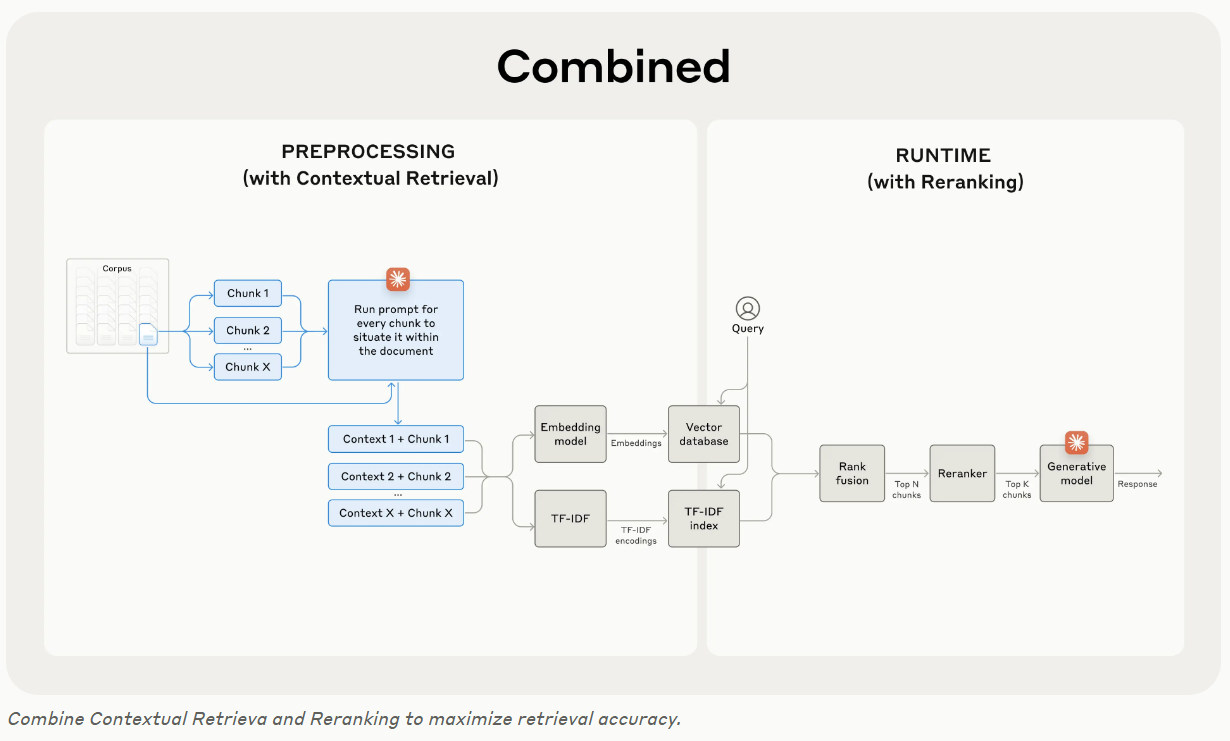

# Table of Content
1. Data Processing
2. Vectore Storing
3. TF-IDF index storing
4. Hybrid Retrival
5. Rank Fusion
6. ReRanking
7. Final LLM Chain
---



In [ ]:
'''langchain.debug=True
mmr'''

In [29]:
import warnings
warnings.filterwarnings('ignore')
!pip install -qU langchain_community pypdf
!pip install -qU langchain_google_genai
!pip install -qU langchain-pinecone
!pip install -qU langchain-core
!pip install -qU pinecone-client
!pip install --upgrade --quiet  rank_bm25

## Data Loading

In [2]:
from langchain_community.document_loaders import PyPDFLoader

def pdf_loader(file_path):

  loader = PyPDFLoader(
      file_path
  )

  docs = loader.load()
  return docs


In [3]:
!wget https://sgp.fas.org/crs/misc/IF10244.pdf

file_path =  "/content/IF10244.pdf"
docs = pdf_loader(file_path)

--2024-11-09 12:02:02--  https://sgp.fas.org/crs/misc/IF10244.pdf
Resolving sgp.fas.org (sgp.fas.org)... 3.166.96.8, 3.166.96.110, 3.166.96.31, ...
Connecting to sgp.fas.org (sgp.fas.org)|3.166.96.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435826 (426K) [application/pdf]
Saving to: ‘IF10244.pdf’

IF10244.pdf         100%[===================>] 425.61K  1.58MB/s    in 0.3s    

2024-11-09 12:02:03 (1.58 MB/s) - ‘IF10244.pdf’ saved [435826/435826]



In [4]:
len(docs)

3

## Context Part Adding

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from google.colab import userdata
from typing import List
import time
import os

def enrich_chunks_with_context(
    documents: List[Document],
    chunk_size: int = 700,
    chunk_overlap: int = 200,
    model_name: str = "gemini-1.5-flash"
) -> List[Document]:
    """
    Processes documents by splitting them into chunks and adding AI-generated context summaries.

    Args:
        documents: List of LangChain Document objects
        chunk_size: Size of text chunks
        chunk_overlap: Overlap between chunks
        model_name: Google Generative AI model to use


    Returns:
        List of Document objects with enriched content
    """
    # Initialize the text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )

    # Initialize the LLM
    google_api_key = userdata.get('GOOGLE_API_KEY')

    llm = ChatGoogleGenerativeAI(
        google_api_key=google_api_key,
        model=model_name
    )

    # Create prompt template
    prompt_template = PromptTemplate(
        template=(
            "<document> {whole_document} </document> "

            "Here is the chunk we want to situate within the whole document "

            "<chunk> {chunk_content} </chunk> "

            "Please give a short succinct context to situate this chunk within "
            "the overall document for the purposes of improving search retrieval "
            "of the chunk. Answer only with the succinct context and nothing else."
        ),
        input_variables=["whole_document", "chunk_content"]
    )

    # initialize context chain
    context_chain = prompt_template | llm


    enriched_documents = []

    # Process each document
    for doc in documents:
        # Get the full document content
        full_content = doc.page_content

        # Split into chunks
        chunks = text_splitter.split_text(full_content)

        # Process each chunk
        for chunk in chunks:
            try:
                # Generate context using the LLM

                context = context_chain.invoke({
                    "whole_document": full_content,
                    "chunk_content": chunk
                }).content.strip()


                # Create new metadata
                new_metadata = doc.metadata.copy()
                new_metadata.update({
                    'generated_context': context,
                    'original_chunk': chunk,
                    'chunk_size': chunk_size,
                    'chunk_overlap': chunk_overlap,
                    'search_source' : "dense_search"
                })

                # Combine context with original chunk
                enriched_content = f"{context}\n\n{chunk}"

                # Create new document with enriched content
                enriched_doc = Document(
                    page_content=enriched_content,
                    metadata=new_metadata
                )
                enriched_documents.append(enriched_doc)
                time.sleep(3)

            except Exception as e:
                print(f"Error processing chunk: {str(e)}")
                # Add original chunk without enrichment if there's an error
                enriched_documents.append(Document(
                    page_content=chunk,
                    metadata={
                        **doc.metadata,
                        'error': str(e),
                        'processing_status': 'failed'
                    }
                ))

    return enriched_documents


In [18]:
chunks = enrich_chunks_with_context(docs)

In [20]:
print(chunks[0].page_content)

This chunk provides an introductory definition of wildfires and outlines the responsibilities of state and federal governments in responding to wildfires.

https://crsreports.congress.gov 
Updated June 1, 2023
Wildfire Statistics
Wildfires are unplanned fires, including lightning-caused 
fires, unauthorized human-caused fires, and escaped fires 
from prescribed burn projects. States are responsible for 
responding to wildfires that begin on nonfederal (state, 
local, and private) lands, except for lands protected by 
federal agencies under cooperative agreements. The federal 
government is responsible for responding to wildfires that 
begin on federal lands. The Forest Service (FS)—within the 
U.S. Department of Agriculture—carries out wildfire 
management and response across the 193 million acres of


## Vectore Retrieval

In [21]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from uuid import uuid4

def initalize_vector_store(index_name, chunks):
    """
    initalize Pinecone vector database ans create new index for the embeddings of transcript
    than use recursive character splitter and stores in vector store
    here it uses google embeddings because it is effective and currently free to use
    at last it converts vector database in to retiriever for future use in RAG.
    """

    pinecone_api_key = userdata.get("PINECONE_API_KEY")
    pc = Pinecone(api_key = pinecone_api_key)

    existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

    if index_name not in existing_indexes:
        pc.create_index(
            name = index_name,
            dimension= 768,
            metric= "cosine",
            spec=ServerlessSpec(
                cloud="aws",
                region="us-east-1"
            )
        )

        while not pc.describe_index(index_name).status["ready"]:
                time.sleep(1)



    index = pc.Index(index_name)

    # initialize google embeddings
    google_api_key = userdata.get('GOOGLE_API_KEY')
    embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=google_api_key)
    vector_store = PineconeVectorStore(index=index, embedding=embeddings)

    uuids = [str(uuid4()) for _ in range(len(chunks))]

    #insets all documents into database.
    vector_store.add_documents(documents=chunks, ids=uuids)
    retriever = vector_store.as_retriever(search_kwargs={
        "k": 10,
    })

    return retriever

In [22]:
pinecone_retriever = initalize_vector_store("contextual-embeddings", chunks)

## BM25Retriever

In [44]:
from langchain_community.retrievers import BM25Retriever

def initalize_BM25_retriever(docs):
  updated_docs = []
  for doc in docs:
    new_metadata = doc.metadata.copy()
    new_metadata['search_source'] = "BM25"

    # Create new document with updated metadata
    updated_chunk = Document(
        page_content=doc.page_content,
        metadata=new_metadata
    )

    updated_docs.append(updated_chunk)

  bm25_retriever = BM25Retriever.from_documents(updated_docs, k=10)
  return bm25_retriever


In [45]:
bm25_retriever = initalize_BM25_retriever(chunks)

In [46]:
bm25_retriever

BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x7e5db4167160>, k=10)

## Ensemble Retriever

In [101]:
from langchain.retrievers import EnsembleRetriever

ensemble_retriever = EnsembleRetriever(
    retrievers=[pinecone_retriever, bm25_retriever],
    weights=[0.5, 0.5]
)


In [49]:
temp = retriever.get_relevant_documents("This chunk provides an introductory definition of")

14


## ReRanking

In [65]:
!pip install langchain-cohere -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 8.2 MB/s eta 0:00:00


In [91]:
from langchain_cohere import CohereRerank

reranker = CohereRerank(
            cohere_api_key=userdata.get("COHERE"),
            model="rerank-english-v3.0"
        )

In [95]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

def rerank_documents(documents: List[Document], query: str) -> str:
  """
  Rerank documents using Cohere and return document contents.

  Args:
      documents: List of documents to rerank
      query: The query to use for reranking

  Returns:
      Concatenated string of reranked document contents
  """
  if not documents:
      return ""

  # Extract text from documents
  texts = [doc.page_content for doc in documents]

  # Rerank using Cohere with query
  rerank_results = reranker.rerank(
      documents=texts,
      query=query,
      top_n=5
  )

  # Create a mapping of text to original document
  text_to_doc = {doc.page_content: doc for doc in documents}

  # Get reranked documents with their metadata
  reranked_docs = []
  for result in rerank_results:
      # Get the original document text
      original_doc = text_to_doc[texts[result['index']]]

      # Create new document with rerank score in metadata
      reranked_doc = Document(
          page_content=original_doc.page_content,
          metadata={
              **original_doc.metadata,
              'rerank_score': result['relevance_score']
          }
      )
      reranked_docs.append(reranked_doc)

  # Combine reranked document contents
  reranked_text = "\n\n---\n\n".join(
      [f"[Score: {doc.metadata['rerank_score']:.4f}]\n{doc.page_content}"
        for doc in reranked_docs]
  )

  return reranked_text

In [104]:
from langchain_google_genai import GoogleGenerativeAI

def retrieve_and_rerank(input_dict):
      question = input_dict["question"]
      docs = ensemble_retriever.get_relevant_documents(question)
      reranked_context = rerank_documents(docs, question)
      return reranked_context


def create_pipeline(
    documents: List[Document],
    question_template: str = """Answer the question based on the following context:
    Context: {context}
    Question: {question}
    Answer: """
  ):

  prompt = PromptTemplate(
      template=question_template,
      input_variables=["context", "question"]
  )



  #configure LLM
  google_api_key = userdata.get("GOOGLE_API_KEY")
  llm = GoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)
  # Define the pipeline
  rag_chain = (
      {"context": lambda x: retrieve_and_rerank({"question": x}),
        "question": RunnablePassthrough()}
      | prompt
      | llm
      | StrOutputParser()
  )

  return rag_chain




In [105]:
from langchain_core.output_parsers.string import StrOutputParser
chain = create_pipeline(temp)

In [ ]:
import langchain
langchain.debug = True
response = chain.invoke("what is introduction to wildlife")